In [1]:
# ntrain=1500

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
import scipy.io as sio
import torchvision

from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sklearn.metrics import r2_score
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [2]:
def toTensor(array):
    '''Converts a numpy array to a torch tensor.'''
    x = torch.from_numpy(array).type(torch.FloatTensor)
    x.requires_grad = True
    return x

def lossfunc(ypred, ytrue):
    batch = ytrue.shape[0]

    diff = torch.norm((ypred.reshape(batch,-1) - ytrue.reshape(batch,-1)), 2,1)
    ynorm  = torch.norm(ytrue.reshape(batch,-1), 2,1)
    
    err= torch.sum(diff/ynorm)
    
    return err

class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps
        

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()
        



In [3]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride = 1, padding=1)#3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch,kernel_size=3,stride = 1, padding=1)# 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
#             print("before ConvBloc", x.shape)
            x = block(x)
#             print(f'after conv block {x.shape}')
            
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            # print(encoder_features[i].shape, x.shape)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(1,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=3, retain_dim=False, out_sz=(48,48)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz      = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [7]:


################################################################
# configs
################################################################


pathm_5 = '/DATA1/meer/data/material-v3-3350.mat'

pathe_5 = '/DATA1/meer/data/strain-v3-3350.mat'
TRAIN_PATH = pathm_5#'material.mat'
# TEST_PATH = '/content/drive/MyDrive/traj/E22-frame5.mat'
TEST_PATH = pathe_5#'StressStrainData/strainsv2.mat'
# TEST_PATH = '/content/drive/MyDrive/traj/fieldvars-frame5.mat'

ntrain =1200
ntest = 200

batch_size =20

################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)   ### X of train and test
x_train = reader.read_field('Emat')[:ntrain]#,::r,::r][:,:s,:s]   #####[samples,48,48,1]
x_test = reader.read_field('Emat')[-ntest:]# ,::r,::r][:,:s,:s]     #####[samples,48,48,1]
x_test_plot = reader.read_field('Emat')[-ntest:]


reader.load_file(TEST_PATH)  # y data for train and test

# y_train = reader.read_field('E22')[:2*ntrain:2]#     ######[samples,48,48,6]
# y_test = reader.read_field('E22')[2*ntrain:2*ntrain+3*ntest:3] 

y_train = reader.read_field('strain')[:ntrain]#     ######[samples,48,48,6]
y_test_strain = reader.read_field('strain')[-ntest:]    ############[samples,48,48,6]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_strain), batch_size=batch_size, shuffle=False)



if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()


In [8]:
model = UNet().to(device)
print(f'MODEL PARAMETERS. :== {count_params(model)}')
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)  ### gamma =0.1
epochs = 500



MODEL PARAMETERS. :== 31030723


In [12]:

# ep wise error
trainerror=[] 
testerror=[]
dim =48
strain_channels = 3
##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)

        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim,dim,strain_channels)
   

        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x =x.reshape(x.shape[0], 1, dim, dim)
            out = model(x).reshape(batch_size, dim, dim,strain_channels)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 0  ||  TIME(sec):== 2.1411 || TrainError:== 0.72285  ||  TestError:== 0.721667
 Epoch :== 1  ||  TIME(sec):== 2.1475 || TrainError:== 0.719978  ||  TestError:== 0.718969
 Epoch :== 2  ||  TIME(sec):== 2.1522 || TrainError:== 0.717911  ||  TestError:== 0.716999
 Epoch :== 3  ||  TIME(sec):== 2.1391 || TrainError:== 0.715656  ||  TestError:== 0.714015
 Epoch :== 4  ||  TIME(sec):== 2.1512 || TrainError:== 0.714146  ||  TestError:== 0.712922
 Epoch :== 5  ||  TIME(sec):== 2.1496 || TrainError:== 0.712979  ||  TestError:== 0.712683
 Epoch :== 6  ||  TIME(sec):== 2.1548 || TrainError:== 0.712082  ||  TestError:== 0.711108
 Epoch :== 7  ||  TIME(sec):== 2.1468 || TrainError:== 0.710171  ||  TestError:== 0.709557
 Epoch :== 8  ||  TIME(sec):== 2.1434 || TrainError:== 0.70783  ||  TestError:== 0.706456
 Epoch :== 9  ||  TIME(sec):== 2.1558 || TrainError:== 0.703212  ||  TestError:== 0.702569
 Epoch :== 10  ||  TIME(sec):== 2.1559 || TrainError:== 0.695569  ||  TestError:== 0.689437


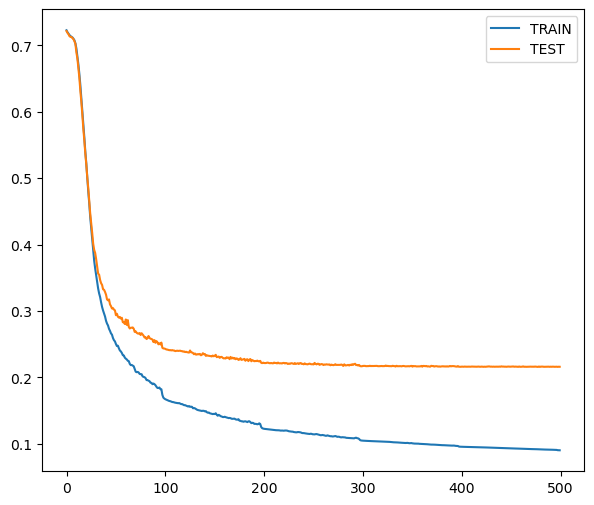

In [13]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror, label ="TRAIN")
plt.plot(range(epochs),testerror, label ="TEST")
plt.legend()
plt.show()

In [14]:
trainn = np.array(trainerror)
testnn = np.array(testerror)
torch.save(model.state_dict(),'UNet_STRAIN_N1200_ep1200.pt')
np.save('trainUNET_STRAIN', trainn)
np.save('testUNET_STRAIN', testnn)

In [15]:
prediction = torch.zeros(y_test_strain.shape)
c = 0
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)
        out = model(x).reshape(batch_size, dim, dim,strain_channels)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

In [16]:
strain_act = y_test_strain.reshape(ntest, -1)
strain_pred = prediction.reshape(ntest,-1)


In [17]:
r2_strain =[]
for i in range(strain_act.shape[0]):
    act = strain_act[i]
    pred = strain_pred[i]
    r2 = r2_score(act,pred)
    # print(r2)
    # break
    r2_strain += [r2]

In [18]:
r2_avg_strain = np.average(r2_strain)
r2_std_strain = np.std(r2_strain)

print(r2_avg_strain,r2_std_strain)

0.9453802804932192 0.037906526061835276


In [36]:
print(np.round(np.array([0.9453802804932192]),2))
print(np.round(np.array([0.037906526061835276]),2))

[0.95]
[0.04]


In [20]:
loss = lossfunc(y_test_strain, prediction)
print(loss/ntest)

tensor(0.2160)


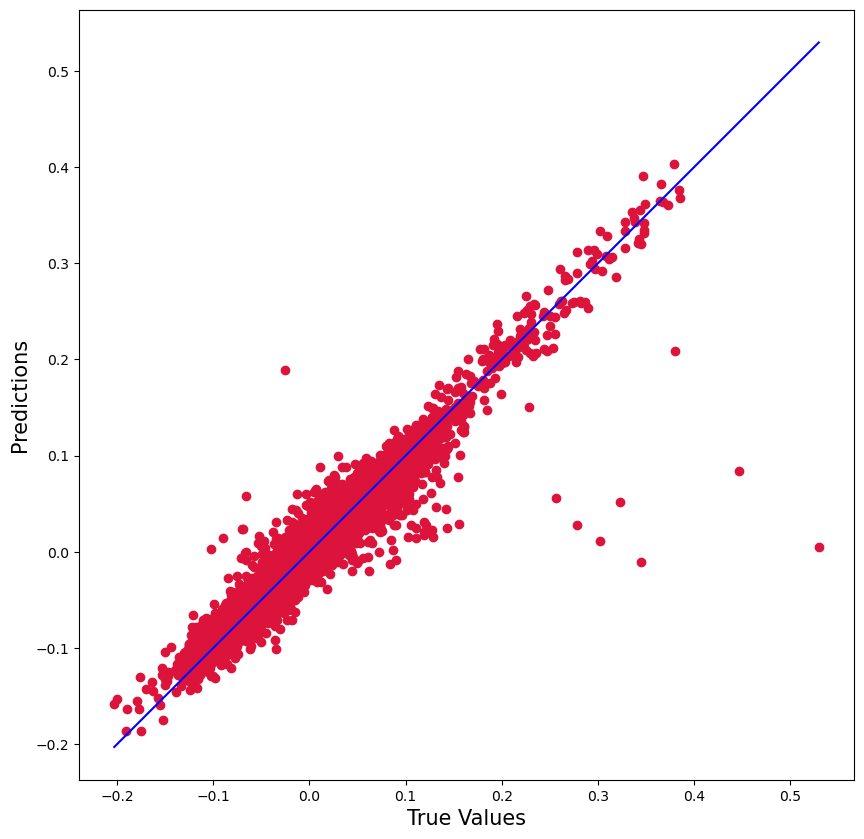

In [77]:
plt.figure(figsize=(10,10))
plt.scatter(y_test_strain.reshape(-1,1), prediction.reshape(-1,1), c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(prediction.reshape(-1,1)), max(y_test_strain.reshape(-1,1)))
p2 = min(min(prediction.reshape(-1,1)), min(y_test_strain.reshape(-1,1)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [78]:
# def rmse(arr1,arr2):
#     W = arr1.shape[0]
#     H = arr1.shape[1]

#     diff = torch.pow((arr1.reshape(-1,1) - arr2.reshape(-1,1)),2).squeeze()

#     summa = torch.sum(diff)

#     normed = summa/(W*H)
#     return normed

In [79]:
# rm = torch.zeros(prediction.shape[0],3)
# for i in range(rm.shape[0]):
#     xx = rmse(prediction[i,...,0], y_test_strain[i,...,0])
#     yy = rmse(prediction[i,...,1], y_test_strain[i,...,1])
#     xy = rmse(prediction[i,...,2], y_test_strain[i,...,2])
#     rm[i]  = torch.tensor([xx,yy,xy])
        

In [113]:
# avg_row = torch.mean(rm, dim = 1)

In [114]:
# print(torch.mean(avg_row))

### STRESS

In [21]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride = 1, padding=1)#3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch,kernel_size=3,stride = 1, padding=1)# 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
#             print("before ConvBloc", x.shape)
            x = block(x)
#             print(f'after conv block {x.shape}')
            
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            # print(encoder_features[i].shape, x.shape)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(1,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=3, retain_dim=False, out_sz=(48,48)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz      = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [22]:


################################################################
# configs
################################################################


pathm_5 = '/DATA1/meer/data/material-v3-3350.mat'

pathe_5 = '/DATA1/meer/data/stress-v3-3350.mat'
TRAIN_PATH = pathm_5#'material.mat'
# TEST_PATH = '/content/drive/MyDrive/traj/E22-frame5.mat'
TEST_PATH = pathe_5#'StressStrainData/strainsv2.mat'
# TEST_PATH = '/content/drive/MyDrive/traj/fieldvars-frame5.mat'

ntrain =1200
ntest = 200
batch_size =20


################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)   ### X of train and test
x_train = reader.read_field('Emat')[:ntrain]#,::r,::r][:,:s,:s]   #####[samples,48,48,1]
x_test = reader.read_field('Emat')[-ntest:]# ,::r,::r][:,:s,:s]     #####[samples,48,48,1]
x_test_plot = reader.read_field('Emat')[-ntest:]


reader.load_file(TEST_PATH)  # y data for train and test

# y_train = reader.read_field('E22')[:2*ntrain:2]#     ######[samples,48,48,6]
# y_test = reader.read_field('E22')[2*ntrain:2*ntrain+3*ntest:3] 

y_train = reader.read_field('stress')[:ntrain]#     ######[samples,48,48,6]
y_test_stress = reader.read_field('stress')[-ntest:]    ############[samples,48,48,6]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

# x_train = x_train.reshape(ntrain,s,s,1)
# x_test = x_test.reshape(ntest,s,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_stress), batch_size=batch_size, shuffle=False)



if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()


In [23]:
model = UNet().to(device)
print(f'MODEL PARAMETERS. :== {count_params(model)}')
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)  ### gamma =0.1
epochs = 500



MODEL PARAMETERS. :== 31030723


In [24]:
# myloss = LpLoss(size_average=False)

y_normalizer.cuda()

# ep wise error
trainerror=[] 
testerror=[]
dim =48
strain_channels = 3
##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)

        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,strain_channels)
   

        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x =x.reshape(x.shape[0], 1, dim, dim)
            out = model(x).reshape(batch_size, dim, dim,strain_channels)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 0  ||  TIME(sec):== 1.4905 || TrainError:== 0.560044  ||  TestError:== 0.550902
 Epoch :== 1  ||  TIME(sec):== 1.481 || TrainError:== 0.547123  ||  TestError:== 0.549962
 Epoch :== 2  ||  TIME(sec):== 1.4644 || TrainError:== 0.546283  ||  TestError:== 0.548677
 Epoch :== 3  ||  TIME(sec):== 1.4608 || TrainError:== 0.543451  ||  TestError:== 0.545191
 Epoch :== 4  ||  TIME(sec):== 1.4645 || TrainError:== 0.541689  ||  TestError:== 0.544657
 Epoch :== 5  ||  TIME(sec):== 1.4606 || TrainError:== 0.540992  ||  TestError:== 0.54422
 Epoch :== 6  ||  TIME(sec):== 1.4684 || TrainError:== 0.540748  ||  TestError:== 0.544351
 Epoch :== 7  ||  TIME(sec):== 1.4541 || TrainError:== 0.540509  ||  TestError:== 0.543728
 Epoch :== 8  ||  TIME(sec):== 1.4533 || TrainError:== 0.539908  ||  TestError:== 0.543181
 Epoch :== 9  ||  TIME(sec):== 1.4584 || TrainError:== 0.539467  ||  TestError:== 0.542257
 Epoch :== 10  ||  TIME(sec):== 1.4569 || TrainError:== 0.539004  ||  TestError:== 0.541867


In [25]:
trainn = np.array(trainerror)
testnn = np.array(testerror)
torch.save(model.state_dict(),'UNet_STRESS_N1200_ep1200.pt')
np.save('trainUNET_STRESS', trainn)
np.save('testUNET_STRESS', testnn)

In [26]:
prediction = torch.zeros(y_test_stress.shape)
c = 0
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)
        out = model(x).reshape(batch_size, dim, dim,strain_channels)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

In [27]:
stress_act = y_test_stress.reshape(ntest, -1)
stress_pred = prediction.reshape(ntest,-1)

r2_stress =[]
for i in range(stress_act.shape[0]):
    act = stress_act[i]
    pred = stress_pred[i]
    r2 = r2_score(act,pred)
    r2_stress += [r2]

In [28]:
r2_avg_strain = np.average(r2_strain)
r2_std_strain = np.std(r2_strain)

print(r2_avg_strain,r2_std_strain)

0.9453802804932192 0.037906526061835276


In [33]:
print(np.round(np.array([0.9453802804932192]),2))
print(np.round(np.array([0.037906526061835276]),2))

[0.95]
[0.04]


/home/user/anaconda3/envs/mehran/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/user/anaconda3/envs/mehran/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


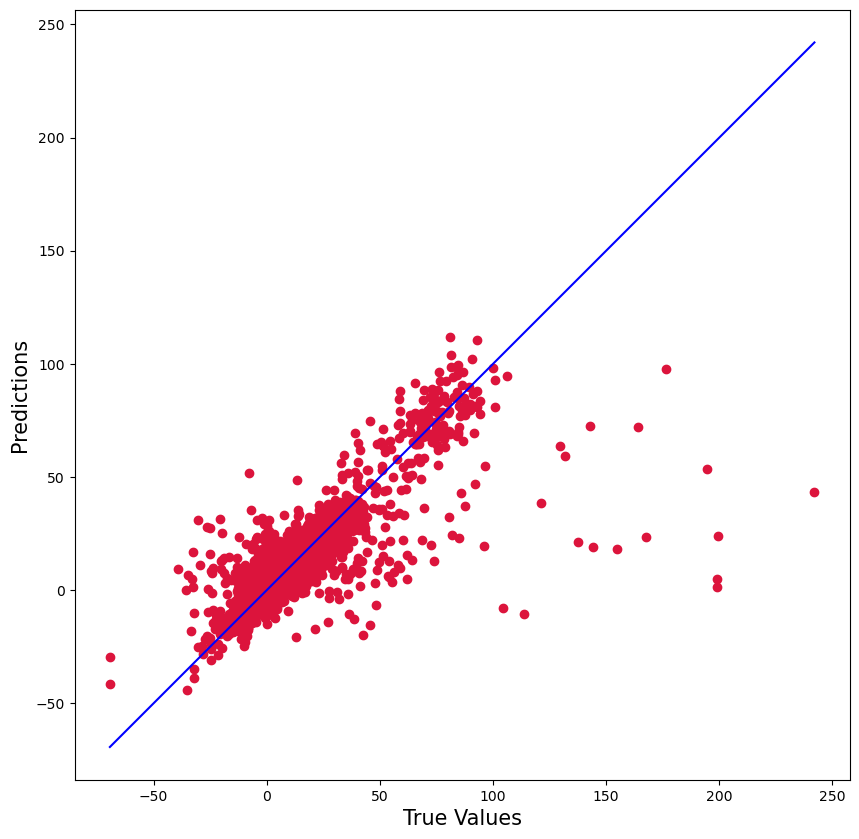

In [99]:
plt.figure(figsize=(10,10))
plt.scatter(y_test_strain.reshape(-1,1), prediction, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(prediction.reshape(-1,1)), max(y_test_strain.reshape(-1,1)))
p2 = min(min(prediction.reshape(-1,1)), min(y_test_strain.reshape(-1,1)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [34]:
loss = lossfunc(prediction.reshape(ntest,-1), y_test_stress.reshape(ntest,-1))
print(loss/ntest)

tensor(0.2441)


In [35]:
loss = lossfunc(y_test_stress.reshape(ntest,-1),prediction.reshape(ntest,-1 ))
print(loss/ntest)

tensor(0.2429)
